In [1]:
!pip install tensorflow

In [2]:

!pip install opencv-python
!pip install seaborn
!pip install scikit-learn
!pip install matplotlib
!pip install pandas
!pip install numpy

  Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas 2.1.4 requires numpy<2,>=1.26.0; python_version >= "3.12", but you have numpy 2.2.6 which is incompatible.
matplotlib 3.8.2 requires numpy<2,>=1.21, but you have numpy 2.2.6 which is incompatible.
scipy 1.11.4 requires numpy<1.28.0,>=1.21.6, but you have numpy 2.2.6 which is incompatible.
scikit-learn 1.3.2 requires numpy<2.0,>=1.17.3, but you have numpy 2.2.6 which is incompatible.
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.w

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

2025-10-05 13:40:53.879511: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
IMG_SIZE = 48
BATCH_SIZE = 64
EPOCHS = 20
SEED = 42
CLASS_LABELS = ["happy", "sad"]

In [5]:
train_dir = "./emotion_data/train"
test_dir = "./emotion_data/test"

def load_images_from_folder(folder, label):
    images, labels = [], []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0  # normalize
            images.append(img)
            labels.append(label)
    return images, labels

def load_dataset():
    X, y = [], []

    for idx, emotion in enumerate(CLASS_LABELS):
        folder = os.path.join(train_dir, emotion)
        imgs, lbls = load_images_from_folder(folder, idx)
        X.extend(imgs)
        y.extend(lbls)

    return np.array(X), np.array(y)

X, y = load_dataset()

print("Dataset shape:", X.shape, y.shape)
print("Class distribution:", pd.Series(y).value_counts())

Dataset shape: (12045, 48, 48, 3) (12045,)
Class distribution: 0    7215
1    4830
Name: count, dtype: int64


In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

y_train = to_categorical(y_train, num_classes=len(CLASS_LABELS))
y_val = to_categorical(y_val, num_classes=len(CLASS_LABELS))

print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)


Train set: (9636, 48, 48, 3) (9636, 2)
Validation set: (2409, 48, 48, 3) (2409, 2)


In [7]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(len(CLASS_LABELS), activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-05 13:41:03.667174: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,778 (1.36 MB)

 Trainable params: 355,778 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/20


2025-10-05 13:41:22.169174: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 266416128 exceeds 10% of free system memory.


150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5960 - loss: 0.6737

2025-10-05 13:41:35.283778: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 66604032 exceeds 10% of free system memory.


151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.6120 - loss: 0.6606 - val_accuracy: 0.6696 - val_loss: 0.6090
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.7229 - loss: 0.5341 - val_accuracy: 0.7771 - val_loss: 0.4503
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.7955 - loss: 0.4320 - val_accuracy: 0.8153 - val_loss: 0.3971
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.8240 - loss: 0.3846 - val_accuracy: 0.8248 - val_loss: 0.3677
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.8433 - loss: 0.3486 - val_accuracy: 0.8406 - val_loss: 0.3496
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.8556 - loss: 0.3180 - val_accuracy: 0.8535 - val_loss: 0.3283
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.8760 - loss: 0.2862 - val_accuracy: 0.8580 - val_loss: 0.3162
Epoch 8/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.8869 - loss: 0.2613 - val_accurac

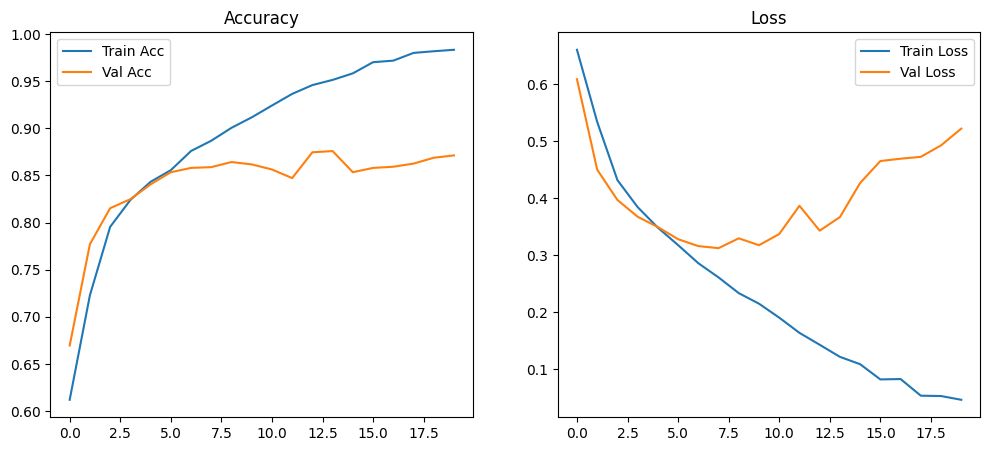

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()


13/76 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

2025-10-05 13:48:54.769424: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 66604032 exceeds 10% of free system memory.


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Classification Report:
              precision    recall  f1-score   support

       happy       0.90      0.88      0.89      1443
         sad       0.83      0.85      0.84       966

    accuracy                           0.87      2409
   macro avg       0.87      0.87      0.87      2409
weighted avg       0.87      0.87      0.87      2409



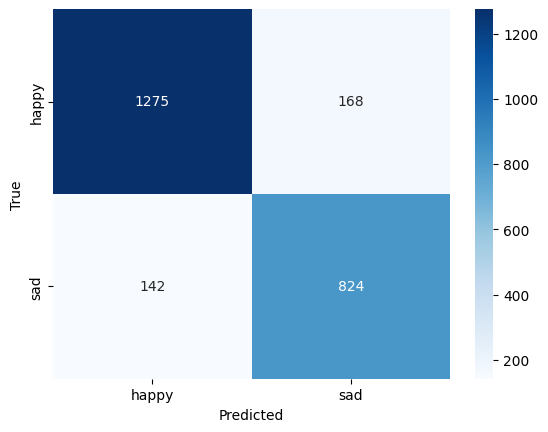

In [10]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=CLASS_LABELS))

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [12]:
model.save("happy_sad_model.h5")          # HDF5 format
model.save("happy_sad_model.keras")             # TensorFlow SavedModel format
print("Model saved!")

Model saved!


In [ ]:
def predict_emotion(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)[0]
    predicted_class = np.argmax(preds)
    confidence = preds[predicted_class]

    return CLASS_LABELS[predicted_class], confidence


test_image_path = os.path.join(test_dir, "happy", os.listdir(os.path.join(test_dir, "happy"))[0])
label, score = predict_emotion(test_image_path)
print(f"Prediction: {label} (Confidence: {score:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction: happy (Confidence: 1.00)
